Copyright © 2023 ETH Zurich
All rights reserved.

This software may be modified and distributed under the terms
of the GPL-3.0 license.  See the LICENSE file for details.

Author: Carl Friess

In [1]:
!gcc -c -fpic mapping.c && gcc -shared -o libmapping.so mapping.o

mapping.c:192:33: warning: incompatible pointer types passing 'int16_t[32]' to parameter of type 'int16_t (*)[8]' [-Wincompatible-pointer-types]
    scan_extract_points(pos[i], tof_mm[i], max_range_mm, &xy_buf);
                                ^~~~~~~~~
mapping.c:114:46: note: passing argument to parameter 'tof' here
void scan_extract_points(float* pos, int16_t tof[4][8], int16_t max_range, xy_buffer_t *buffer) {
                                             ^
1 warning generated.


In [2]:
import math
import os.path
import struct

import matplotlib.pyplot as plt
import numpy as np

from log import load_poses_cf, load_poses_vicon, load_scans
from mapping_bridge import pcloud_to_map2

In [3]:
path = "data/exp1/four-drones/"

In [4]:
data_cf = load_poses_cf(os.path.join(path, "poses.csv"))
data_vicon = load_poses_vicon(os.path.join(path, "vicon_poses.csv"))
scans = load_scans(os.path.join(path, "scans.csv"))

In [5]:
def extract_points(scan, x, y, yaw, max_measurement=math.inf):

    offsets = [0.02, 0.02, 0.025, 0.025]
    step = -math.pi / 4 / 8

    [pose_id] = struct.unpack("<Hxx", scan[:4])

    poses = []
    points = []
    for frame in [scan[4 + i:4 + i + 76] for i in range(0, 15 * 76, 76)]:
        [dx, dy, dyaw] = struct.unpack("<fff", frame[64:])
        frame_x = x + dx
        frame_y = y + dy
        frame_yaw = yaw + dyaw
        for dir in range(4):
            angle = -4 * step + step / 2
            dir_yaw = frame_yaw
            if dir == 1:
                dir_yaw += math.pi
            elif dir == 2:
                dir_yaw += math.pi / 2
            elif dir == 3:
                dir_yaw -= math.pi / 2
            for col in range(8):

                [measurement] = struct.unpack("<h", frame[dir * 8 * 2 + col * 2:dir * 8 * 2 + col * 2 + 2])
                if measurement < 0 or measurement / 1000 > max_measurement: continue

                dist_x = measurement / 1000
                dist_y = math.tan(angle) * dist_x
                dist_x += offsets[dir]
                p_x = frame_x + dist_x * math.cos(dir_yaw) - dist_y * math.sin(dir_yaw)
                p_y = frame_y + dist_x * math.sin(dir_yaw) + dist_y * math.cos(dir_yaw)
                poses.append([frame_x, frame_y, frame_yaw])
                points.append([p_x, p_y])

                angle += step

    return poses, points

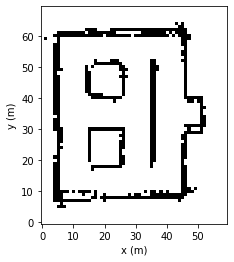

In [6]:
poses = []
points = []
for id in scans.keys():
    s_poses, s_points = extract_points(scans[id], data_cf[id][-1][0], data_cf[id][-1][1], data_cf[id][-1][2])
    poses += s_poses
    points += s_points
matrix = pcloud_to_map2(np.array(poses), np.array(points), 0, -2, -3.5, 6, 7, 0.1).transpose()
matrix = matrix > 20
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel("x (m)")
ax.set_ylabel("y (m)")
cax = ax.matshow(matrix, cmap='Greys', interpolation="nearest")
ax.invert_yaxis()
plt.gca().xaxis.tick_bottom()
plt.savefig("exp1-four-drones-binary-map.pdf", dpi=400, bbox_inches="tight")
plt.show()
plt.close()